In [16]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image, ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate


In [17]:

# Image resizing parameters
img_rows, img_cols = 64, 64
isolated_train_path = 'D:/CXR8/ChestX-ray'
isolated_test_path = 'D:/CXR8/ChestX-ray Test'

In [18]:

# Preprocess images
for root, dirnames, filenames in os.walk(isolated_train_path):
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = Image.open(file_path)
        Grey = img.resize((img_rows, img_cols))
        Grey = Grey.convert('RGB')
        Grey.save(file_path)

In [19]:
# Paths for training and validation data
train_data_dir = isolated_train_path #
validation_data_dir = isolated_test_path

In [20]:
# Image data parameters
img_width, img_height, channel = img_rows, img_cols, 3
batch_size = 64

In [21]:
# Data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [22]:
# Training and validation data generators
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)


Found 10500 images belonging to 15 classes.


In [23]:
validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

Found 2100 images belonging to 15 classes.


In [24]:
# Model parameters
IMG_SHAPE = img_cols, img_rows, 3
classes = 15
num_epoch = 30
num_train_samples = train_generator.samples
###################################################num_train_samples =  train_data_dir
num_validation_samples = validation_generator.samples

################################################### num_validation_samples = validation_data_dir

In [25]:
print('num_train_samples: ' + str(num_train_samples))
print('num_validation_samples: ' + str(num_validation_samples))

num_train_samples: 10500
num_validation_samples: 2100


In [26]:

# Model building functions
def batch_normalization_relu_conv(x, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [27]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = batch_normalization_relu_conv(tensor, filters=4*k, kernel_size=1)
        x = batch_normalization_relu_conv(x, filters=k, kernel_size=3)
        tensor = Concatenate()([tensor, x])
    return tensor

In [28]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = batch_normalization_relu_conv(x, filters=f, kernel_size=1)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

In [29]:
# Model architecture
k = 8 # 12 actual .. then 
theta = 0.5
repetitions = 10, 14, 16
input_layer = Input(IMG_SHAPE)
x = Conv2D(2*k, 7, strides=2, padding='same')(input_layer)
x = Dropout(0.1)(x) #  actual 0.2
x = MaxPool2D(3, strides=2, padding='same')(x) # 3 actual 

In [30]:
for reps in repetitions:
    x = dense_block(x, k, reps)
    x = transition_layer(x, theta)

In [31]:
x = GlobalAvgPool2D()(x)
output_layer = Dense(classes, activation='softmax')(x)

In [32]:
model = Model(input_layer, output_layer)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   2368        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 16)   0           ['dropout[0][0]']                
                                                                                              

In [33]:
# Model compilation
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001) # 0.001 actual
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [34]:
# Model training
history_1 = model.fit(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size
)

Epoch 1/30
164/164 [==============================] - 97s 518ms/step - loss: 2.6258 - accuracy: 0.1302 - val_loss: 4.3595 - val_accuracy: 0.0684
Epoch 2/30
164/164 [==============================] - 39s 235ms/step - loss: 2.5287 - accuracy: 0.1628 - val_loss: 2.7504 - val_accuracy: 0.1016
Epoch 3/30
164/164 [==============================] - 39s 237ms/step - loss: 2.4888 - accuracy: 0.1755 - val_loss: 6.8346 - val_accuracy: 0.0820
Epoch 4/30
164/164 [==============================] - 39s 236ms/step - loss: 2.4638 - accuracy: 0.1739 - val_loss: 2.9187 - val_accuracy: 0.1030
Epoch 5/30
164/164 [==============================] - 39s 237ms/step - loss: 2.4466 - accuracy: 0.1850 - val_loss: 2.7084 - val_accuracy: 0.1270
Epoch 6/30
164/164 [==============================] - 40s 243ms/step - loss: 2.4206 - accuracy: 0.1915 - val_loss: 2.9320 - val_accuracy: 0.1025
Epoch 7/30
164/164 [==============================] - 39s 237ms/step - loss: 2.4054 - accuracy: 0.1937 - val_loss: 2.6545 - val_ac

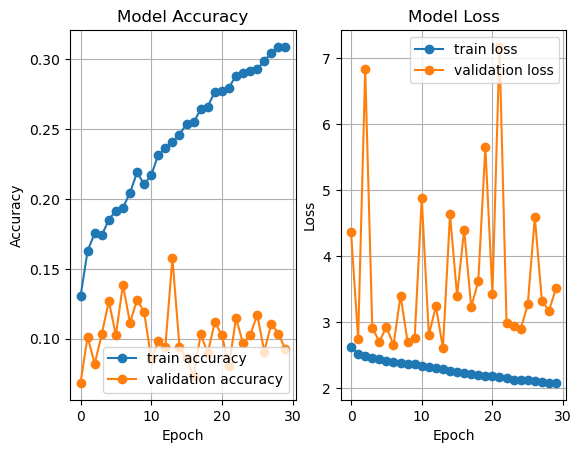

In [38]:
# Plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history_1.history['val_accuracy'], 'o-', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history_1.history['loss'], 'o-', label='train loss')
plt.plot(history_1.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [36]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
Y_pred = model.predict(validation_generator, num_validation_samples// batch_size)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
y_true= validation_generator.classes

target_names = ['62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76' ]
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

33/33 [==============================] - 25s 721ms/step
(2100, 15)
              precision    recall  f1-score   support

          62      0.000     0.000     0.000       140
          63      0.076     0.571     0.134       140
          64      0.000     0.000     0.000       140
          65      0.135     0.136     0.135       140
          66      0.093     0.557     0.160       140
          67      0.000     0.000     0.000       140
          68      0.000     0.000     0.000       140
          69      0.000     0.000     0.000       140
          70      0.000     0.000     0.000       140
          71      0.000     0.000     0.000       140
          72      0.000     0.000     0.000       140
          73      0.000     0.000     0.000       140
          74      0.000     0.000     0.000       140
          75      0.000     0.000     0.000       140
          76      0.111     0.007     0.013       140

    accuracy                          0.085      2100
   macro avg 

d:\Application Installed\anacondaa\envs\sheakh310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Application Installed\anacondaa\envs\sheakh310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Application Installed\anacondaa\envs\sheakh310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr